In [1]:
import os
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
from dotenv import load_dotenv
from tqdm import tqdm
from langchain_community.vectorstores import Chroma
from langchain.schema import Document
import matplotlib.pyplot as plt

## To run Hugging Face OpenSource models
# Needs to manually install Visual C++ Tools from: https://visualstudio.microsoft.com/visual-cpp-build-tools/
from InstructorEmbedding import INSTRUCTOR
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
from langchain_community.vectorstores import Chroma

#For some reason, "context" cant be used as input variable, it should be named as "summaries"
from langchain.chains import RetrievalQAWithSourcesChain
#from langchain_ollama import OllamaLLM
from langchain_openai import ChatOpenAI
#from openai import OpenAI
from langchain.prompts import PromptTemplate
import warnings
from rich import print
import random, re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#from spellchecker import SpellChecker
import spacy
from langchain_openai  import OpenAIEmbeddings

from nltk.stem import WordNetLemmatizer
from transformers import MarianMTModel, MarianTokenizer
import yake
import nltk
from textblob import TextBlob


# Download necessary NLTK data (run this only once)
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('omw-1.4')

# Suppress all warnings
warnings.filterwarnings("ignore")

c:\ProgramData\anaconda3\envs\rag\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange
c:\ProgramData\anaconda3\envs\rag\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\ProgramData\anaconda3\envs\rag\Lib\site-packages\torchvision\t

In [2]:
import torch
import torch.nn as nn

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")

# Print CUDA device name
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True

Device Name: NVIDIA GeForce RTX 4060 Laptop GPU

### Activando CUDA para acelerar el procesamiento de vectores ###

In [3]:
# Ensure GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda

### Definición de hiperparametros

In [4]:
index_test_name = 'OpenAI-table'
LLM_model = 'gpt-4o'
#LLM_model = 'gpt-3.5-turbo-0125'
temperature_parameter=0
retriever_matches_k = 3

## Save each iteration to file
output_file_path = '../Predicciones_GPT4o_OpenAI_table.csv'
#output_file_path = '../Predicciones_GPT3_5Turbo0125_OpenAI_table.csv'

df = pd.read_csv('../validation_dataset/Validation data reviewed.csv', encoding='utf-8', dtype=str)

In [5]:
# Define directories
# Define the persistent directory containing the VectorDB
script_dir =  os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir,'..' ,'index', index_test_name))

# Load environment variables from the .env file
load_dotenv()
# Initialize OpenAI client with the API key from environment variables
open_ai_embed_model = OpenAIEmbeddings(openai_api_key= os.environ["OPENAI_API_KEY"],
             model="text-embedding-3-large", 
             request_timeout=8,
             retry_min_seconds=4,
             show_progress_bar=True,
             )

llm_model = ChatOpenAI(model=LLM_model, 
                  temperature=temperature_parameter,
                  openai_api_key= os.environ["OPENAI_API_KEY"]
                  )

### Se crea la estructura del RAG
Utiliza HuggingFaceInstructEmbeddings para generar embeddings de descripciones de productos.

Almacena y gestiona embeddings en una base de datos vectorial Chroma.

Recupera documentos más relevantes basados en similitud con un retriever ajustado a los mejores 3 resultados.

Utiliza el modelo de lenguaje Llama3 para predecir el código HS más preciso a partir de descripciones.

Limita la respuesta a un único código HS, extraído del documento con mayor similitud.

Define una plantilla personalizada para guiar las respuestas del modelo.

In [6]:
# loading the vectorstore
vectorstore = Chroma(persist_directory=persistent_dir, embedding_function=open_ai_embed_model)
# casting  the vectorstore as the retriever, taking the best 3 similarities
retriever = vectorstore.as_retriever(search_kwargs={"k":retriever_matches_k})

# formating the docs
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#template = """You must respond only with the hs_code from the metadata of the source_documents retrieved by the retriever.
#with the highest similarity score, avoid responding with any kind of text 
#even if you can be sure if the HS code is correct like 
#"I'm unable to provide a response..." or "I cannot provide a response".


template = """You must strictly respond with the HS code that matches the information contained in the 'source' 
field of the metadata from the source_documents provided. You are not allowed to respond with any HS code from your own knowledge. 
Do not invent or guess. Only respond with one HS code from the provided metadata that has the highest relevance score from the retriever, 
and it must be from the 'source' field.

For example, if the source document mentions 'Potato starch' with 'source': '1108.13', your answer must be '1108.13'.

Avoid responding with any other text.Respond only with 1 HS code, the one with better score from the retriever.


context:
{summaries}

Question:
{question}
"""

# Define the LLM chain (using the Llama3.1 model)
llm_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_model,
    chain_type='stuff',
    retriever=retriever,
    return_source_documents=True,  # To get both the answer and source docs
    chain_type_kwargs={
            "prompt": PromptTemplate(
                template=template,
                #For some reason, "context" cant be used as input variable, it should be named as "summaries"
                input_variables=["question", "summaries"],
            ),
        },
)

context = """As a logistics shipping arrival inspector, your primary responsibility is to inspect incoming shipments and accurately classify goods 
using the Harmonized System (HS) code based on the descriptions provided in the shipping manifests. You will thoroughly review the manifest details, 
including product type, material composition, function, and intended use, to determine the correct HS code. 

Your task is to:
Carefully read and analyze the product descriptions from the manifest.
Identify key characteristics of the goods, such as 
type (e.g., electronics, textiles, machinery), 
material (e.g., plastic, metal, organic), 
and usage (e.g., household, industrial, medical)
Use your knowledge of the HS code classification system to assign the most appropriate HS code for each product based on its description.
Ensure compliance with international trade regulations by selecting precise codes to avoid delays or penalties.
Remember to be thorough and accurate in your classification, as this impacts customs processing, tariffs, and legal requirements."""



### Set the pre-processing cleaning pipeline

In [7]:
# Set up YAKE keyword extractor
yake_extractor = yake.KeywordExtractor()

language = "en"
max_ngram_size = 3
deduplication_threshold = 0.1
numOfKeywords = 20
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

# Load the translation model (use Spanish-to-English model)
model_name = 'Helsinki-NLP/opus-mt-es-en'  # Spanish to English model
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
# Get the English words corpus and English stopwords
#english_words = set(words.words())
english_stopwords = set(stopwords.words('english'))
# Add your custom stopwords
additional_stopwords = {
    # Add your custom stopwords here (same as your provided list)
    'hs', 'code', 'hscode', 'hs-code', 'hs  code', 'pallets', 'plts', 'shipper', 'declares', 'hs code',
    'containing', 'contains', 'meter', 'cubic', 'packages', 'load', 'loaded', 'weight', 
    'netweight', 'kg', 'kgs', 'cb', 'cbm', 'goods', 'parts', 'pieces', 'accessories', 'packing', 
    'declared', 'dangerous', 'impression', 'items', 'sheets', 'codes', 
    'sin', 'impresion', 'containers', 'pc', 'abv', 'net', 'gross', 'cif', 'aduana', 'customs', 
    'value', 'tax', 'duty', 'freight', 'port', 'terminal', 'consignee', 'consignor', 'invoice', 
    'manifest', 'quantity', 'description', 'volume', 'packaging', 'shipment', 'delivery', 'origin', 
    'destination', 'transport', 'carrier', 'export', 'import', 'tariff', 'item', 'declaration', 
    'clearance', 'documentation', 'commercial', 'charge', 'fees', 'logistics', 'shipping', 
    'container', 'unit', 'measurement', 'certification', 'palletized', 'metric', 'commodity', 
    'classification', 'entry', 'exportation', 'importation', 'bonded', 'zone', 'trade', 'license', 'bottle', 'bottles', 'cl',
    'ancho', 'largo', 'mm', 'pcs', 'xhc', 'stc', 'uks','x','k', 'pty', 'id', 'cp', 'ncm', 'ne', 'itpa', 'zz', 'xg', 'topmag',
    'rtmx', 'fcl', 'cf','f', 'xdc', 'pkgs', 'voice', 'n', 'per', 'email'
}

def lemmatize_translate_clean(text):
    keywords = text.split()
    valid_keywords = [keyword for keyword in keywords if keyword not in additional_stopwords]
    lematized_keywords = [lemmatizer.lemmatize(keyword) for keyword in valid_keywords]

    ### Lemmatize the extracted keywords
    ##lemmatized_keywords = [lemmatizer.lemmatize(keyword[0]) for keyword in keywords]
    lemmatized_sentence = " ".join(lematized_keywords)

    ### Correct typos in the lemmatized keywords
    ##corrected_keywords = [str(TextBlob(keyword).correct()) for keyword in lemmatized_keywords]
    ##lematized_and_corrected_typos_sentence = " ".join(corrected_keywords)

    ##lemmatize_translate_clean_text = []
    ##flattened_items = [word for item in lemmatized_keywords for word in item.split()]
    ###print(flattened_items)
    ##for item in flattened_items:
    ##    lemma = lemmatizer.lemmatize(item)
    ##    #Removing condition to check if the word exists on english dictionary, cartulin was not there for example
    ##    #if lemma in english_words and lemma not in english_stopwords:
    ##    if lemma in lemma not in english_stopwords:            
    ##        lemmatize_translate_clean_text.append(lemma)
    #print(english_existing_words)
    return lemmatized_sentence

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    # Remove punctuation and numbers
    text = re.sub(r'[\d]+|[^\w\s]', '', text)  # Remove numbers and punctuation
    return text.strip()

# Function to translate text to English
def translate_to_english(text, tokenizer, model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")
    # Generate translation
    translated = model.generate(**inputs)
    # Decode and return the translated text
    return tokenizer.decode(translated[0], skip_special_tokens=True)


# Full pipeline function
def process_text(text):
    try:
        # Step 1: Preprocess
        preprocessed_text = preprocess_text(text)
        
        # Step 2: Translate
        translated_text = translate_to_english(preprocessed_text, tokenizer, model)
        
        # Step 3: Lemmatize, remove nonsense words, and clean
        final_cleaned_text = lemmatize_translate_clean(translated_text)

        return final_cleaned_text
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

### Test de descripciones 'Hardcoded' para verificar viabilidad de corrida Montecarlo

In [8]:
#query = "sodium lignosulphonate"
#query = "kilogram organic coffee bean certified fairtrade utz roasted usa global distribution"
#query = "prepaid cartons wine"
#query = "wine"
#query = "guide rod caliper"
#query = "said contain plastic drum h msku dry shipper seal pw plastic drum h stowed methyl butyric acid corrosive liqu"
#query = "modified potato starch starch emflo kp"
#query = "CARTULINA NEGRA BOB 170 GRS HS CODE 480258 CARTULINA BLANCA BOB 210 GRS HS CODE 480258"
#query = "wooden cases delivery list"
#query = "pharmaceuticals aspirin protection code pal"
#query = "plastic bottles"
#query = "HERRAJES PARA MUEBLES HS CODE 83024200 EMAIL G.GIACOMO RAGO-GROUP.COM"
query = "glassware ma rk mould noquantity"

# Clean the input text and send to LLM
#For some reason, "context" cant be used as input variable, it should be named as "summaries"
result = llm_chain({"question": process_text(query), "summaries": context})
print(f"[bold yellow]The requested item's description CLEANED to search HTS code is:[/bold yellow]\n{process_text(query)}")
print(f"[bold green]The response of the LLM is:[/bold green]\n{result['answer']}")

#print(result.keys())
#print(result["summaries"])
#print(result["sources"])

print("The documents sent to the LLM are:")
for i in range(len(result["source_documents"])):
    print(result["source_documents"][i].page_content)
    print(result["source_documents"][i].metadata)
    
#results = vectorstore.similarity_search_with_score(query=query, k=retriever_matches_k)
#print("Top n coincidences from the index are:")
#for doc, score in results:
#    print(f"Document content: {doc.page_content}, Code: {doc.metadata},Similarity Score: {score}")


# Find the document with the highest score
#max_doc, max_score = max(results, key=lambda x: x[1])
#print("Best match from the index is:")
#print(f"Document content: {max_doc.page_content}, Code: {max_doc.metadata}, Similarity Score: {max_score}")



100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


The requested item's description CLEANED to search HTS code is:
glassware ma rk mould noquantity

The response of the LLM is:
7013.49

The documents sent to the LLM are:

### Corrida montecarlo, 50 iteraciones de muestreos de 30 despcripciones cada una. 

El resultado se vacia en un csv para verificacion detallada de cada codigo

In [9]:
def run_predictions(descriptions_to_predict):
    
    # Select 30 random queries
    # Shuffle the original DataFrame
    #df_shuffled = all_queries.sample(frac=1).reset_index(drop=True)
    #selected_queries = df_shuffled.sample(descriptions_to_predict)

    # Evaluate in order all the dataset
    selected_queries = all_queries.head(descriptions_to_predict).reset_index(drop=True)


    # Now, process each query with llm_chain
    #print("Predicting HS codes of random Validation Data rows...")
    for index, row in selected_queries.iterrows():
        query = process_text(row['Raw_data_input'])
        expected_output = row['Expected_output']

        # Execute the LLM chain (using a mock prediction for illustration here)
        result = llm_chain({"question": query, "summaries": context})  # This is the actual call
        llm_prediction = result['answer']  # Assuming LLM returns a numeric 6-digit value as the prediction

        # Append the result in the required structure
        results.append({
            "Raw_data_input": row['Raw_data_input'],
            "Raw_data_input_processed": query,
            "LLM_prediction": llm_prediction,  # Here, the prediction from LLM
            "Expected_output": expected_output,
            "Expected_output_two_digits": row['Expected_output_two_digits'],
            "Predicted_output_two_digits": llm_prediction[:2],
            "CorrectMatch_two_digits": 1 if llm_prediction[:2] == row['Expected_output_two_digits'] else 0 ,
            "Expected_output_four_digits": row['Expected_output_four_digits'],
            "Predicted_output_four_digits": llm_prediction[:4],
            "CorrectMatch_four_digits": 1 if llm_prediction[:4] == row['Expected_output_four_digits'] else 0 
        })

    # Convert the results to a DataFrame
    predictions_df = pd.DataFrame(results)

    #Append iteration results to file
    # Check if file exists
    file_exists = os.path.isfile(output_file_path)

    # Append to the file, write header only if file doesn't already exist
    predictions_df.to_csv(output_file_path, mode='a', header=not file_exists, index=False)

    return predictions_df

# Function to calculate accuracy (both for 2 and 4 digits)
def calculate_accuracy(iteration_df):
    correct_two_digits = 0
    correct_four_digits = 0
    total = len(iteration_df)

    for index, row in iteration_df.iterrows():
        best_hs_code = str(row['LLM_prediction'])[:4]
        hs_actual = str(row['Expected_output'])[:4]

        # Check 2-digit accuracy
        if best_hs_code[:2] == hs_actual[:2]:
            correct_two_digits += 1

        # Check 4-digit accuracy
        if best_hs_code == hs_actual:
            correct_four_digits += 1

    accuracy_at_two_digits = correct_two_digits / total if total > 0 else 0
    accuracy_at_four_digits = correct_four_digits / total if total > 0 else 0

    return accuracy_at_two_digits, accuracy_at_four_digits

n_iterations = 2
n_predictions = 30
accuracy_results_list = []
# Create an empty list to store the results
results = []

# Extract the queries from the 'Raw_data_input' column
all_queries = df[['Raw_data_input', 'Expected_output','Expected_output_two_digits', 'Expected_output_four_digits']].dropna()  # Ensure no missing values


#Montecarlo simulation
#for iteration in tqdm(range(n_iterations), desc="Running MonteCarlo simulation", unit="iteration"):
#    #print("Running iteration #:" , iteration+1)
#    iteration_df = run_predictions(n_predictions)
#    # Calculate accuracy
#    acc_two_digits, acc_four_digits = calculate_accuracy(iteration_df)
#
#    # Store the results
#    accuracy_results_list.append([iteration + 1, acc_two_digits, acc_four_digits])
    #print("Accuracy of this iteration: ", acc_two_digits, acc_four_digits)
## Convert results to DataFrame for further analysis
#accuracy_results_df = pd.DataFrame(accuracy_results_list, columns=['Iteration', 'Accuracy_At_Two_Digits', 'Accuracy_At_Four_Digits'])
#accuracy_results_df

#plt.figure(figsize=(10, 6))
#accuracy_results_df[['Accuracy_At_Two_Digits', 'Accuracy_At_Four_Digits']].boxplot()
#plt.title('Monte Carlo Simulation: Accuracy at Two and Four Digits')
#plt.ylabel('Accuracy')
#plt.show()


##### Run 100% of dataset once
acc_two_digits, acc_four_digits = calculate_accuracy(run_predictions(100))
print(f"Accuracy achieved in 100% of the dataset: {acc_two_digits * 100:.2f}% (2-digit), {acc_four_digits * 100:.2f}% (4-digit)")



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Accuracy achieved in 100% of the dataset: 80.00% (2-digit), 63.00% (4-digit)

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Clases únicas en y_true: ['0406' '0602' '0808' '0809' '0904' '0910' '1101' '1108' '1206' '1804'
 '1806' '1905' '2002' '2005' '2201' '2203' '2204' '2208' '2402' '2516'
 '2710' '2829' '2833' '2905' '2906' '2912' '2917' '2918' '2936' '3004'
 '3055' '3304' '3401' '3403' '3505' '3816' '3919' '3920' '3923' '3926'
 '4005' '4011' '4016' '4107' '4407' '4411' '4703' '4707' '4802' '4810'
 '4819' '4901' '5211' '5404' '5703' '6115' '6307' '6802' '6813' '6902'
 '6907' '7002' '7005' '7010' '7013' '7019' '7208' '7214' '7304' '7307'
 '7323' '7502' '8201' '8302' '8303' '8309' '8419' '8422' '8427' '8467'
 '8470' '8472' '8539' '8544' '8707' '8708' '9403' '9406' '9506' '9603']

Clases únicas en y_pred: ['0302' '0406' '0602' '0809' '0810' '0811' '0910' '1101' '1108' '1206'
 '1804' '1806' '1905' '2002' '2005' '2201' '2203' '2204' '2208' '2402'
 '2710' '2829' '2833' '2905' '2906' '2911' '2917' '2918' '2936' '3004'
 '3303' '3401' '3402' '3919' '3920' '3923' '3926' '4011' '4016' '4107'
 '4403' '4411' '4412' '4707' '4802' '4819' '4901' '5402' '5407' '5703'
 '6115' '6307' '6802' '6902' '6907' '7005' '7010' '7013' '7017' '7019'
 '7214' '7304' '7318' '7412' '7616' '8201' '8301' '8302' '8414' '8419'
 '8427' '8441' '8467' '8470' '8479' '8504' '8536' '8544' '8708' '9025'
 '9401' '9403' '9405' '9406' '9506' 'None']

<Figure size 768000x768000 with 0 Axes>

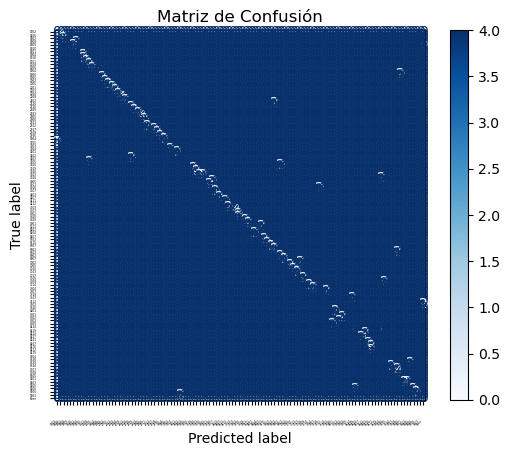

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# Ejecutar las predicciones sobre el conjunto de datos completo
predictions_df = run_predictions(100)  # Cambia el número según tu necesidad

# Crear una matriz de confusión
y_true = predictions_df['Expected_output'].astype(str).str[:4]  # Las etiquetas reales
y_pred = predictions_df['LLM_prediction'].astype(str).str[:4]  # Las predicciones del modelo

# Verificar las clases únicas
unique_classes = np.unique(np.concatenate((y_true, y_pred)))
print("Clases únicas en y_true:", np.unique(y_true))
print("Clases únicas en y_pred:", np.unique(y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
# Ajustar el tamaño de la figura
plt.figure(figsize=(7680, 7680))  # Cambia el tamaño según tus necesidades
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.xticks(rotation=45, ha='right', fontsize=2)  # Rotate x labels and set alignment
plt.yticks(fontsize=2)  # Set y label fontsize

# Adjust label padding
plt.gca().xaxis.set_tick_params(pad=10)  # Increase padding for x-axis ticks
plt.gca().yaxis.set_tick_params(pad=10)  # Increase padding for y-axis ticks
plt.show()
